In [1]:
# some imports
import os
import numpy as np
np.random.seed(seed=1)
from glob import glob
from matplotlib import pyplot as plt
%matplotlib notebook
from natsort import natsorted
import keras
from keras.optimizers import Adam

# import custom functions and viewing tools
from VisTools import multi_slice_viewer0, mask_viewer0
from KerasModel import BlockModel, dice_coef_loss, CalcVolumes

Using TensorFlow backend.


In [2]:
#~# some parameters to set for inference #~#
# model version to use
model_version = 3
model_weights_path = os.path.join(os.getcwd(),
                                  'BestModelWeights_v{:02d}.h5'.format(model_version))
# set data directory
data_dir = os.path.join('/home','bashirmllab','output')

In [3]:
# find data in directory
all_inputs = natsorted(glob(os.path.join(data_dir,"input*.npy")))
all_targets = natsorted(glob(os.path.join(data_dir,"target*.npy")))
print('{} subjects found'.format(len(all_inputs)))
print('Loading data...')
inputs = np.concatenate([np.load(f) for f in all_inputs])[...,np.newaxis]
targets = np.concatenate([np.load(f) for f in all_targets])[...,np.newaxis]
print("Data loaded")

44 subjects found
Loading data...
Data loaded


In [4]:
# prepare model
model = BlockModel(inputs.shape,filt_num=16,numBlocks=4)
model.compile(optimizer=Adam(), loss=dice_coef_loss)

# load best weights
model.load_weights(model_weights_path)
# evaluate on test data
print('Evaluating data...')
score = model.evaluate(inputs,targets,verbose=1)
print("Test Dice score is {:.03f}".format(1-score))

Evaluating data...
1309/1309 [==============================] - 18s 13ms/step
Test Dice score is 0.908


Generating masks...


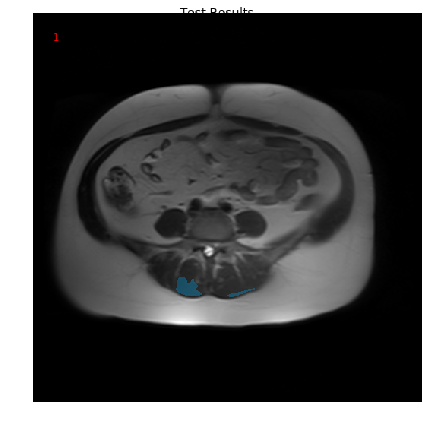

In [5]:
# display some results
print('Generating masks...')
output = model.predict(inputs,batch_size=16)
mask_viewer0(inputs[...,0],targets[...,0],output[...,0],name='Test Results')
plt.show()

In [6]:
# set voxel dimensions (in cm)
sx = .7
sy = .1
sz = .2
vox_vol = sx*sy*sz
# loop over all subjects
results = []
for inp_file,targ_file in zip(all_inputs,all_targets):
    # run function to perform calculations
    calc,truth = CalcVolumes(inp_file,targ_file,vox_vol,model)
    results.append((calc,truth))
    # display result
    print('---------------------------------------')
    print(inp_file[-30:])
    print("The calculated volume is {:.02f} cm^3".format(calc))
    print("The actual volume is {:.02f} cm^3".format(truth))

---------------------------------------
input_JKB01_001_01_A_SSFSE.npy
The calculated volume is 5669.73 cm^3
The actual volume is 5224.31 cm^3
---------------------------------------
input_JKB01_001_01_B_SSFSE.npy
The calculated volume is 6205.02 cm^3
The actual volume is 5811.29 cm^3
---------------------------------------
input_JKB01_001_01_C_SSFSE.npy
The calculated volume is 6796.20 cm^3
The actual volume is 6214.50 cm^3
---------------------------------------
input_JKB01_001_03_A_SSFSE.npy
The calculated volume is 2643.45 cm^3
The actual volume is 2731.25 cm^3
---------------------------------------
input_JKB01_001_03_B_SSFSE.npy
The calculated volume is 2825.28 cm^3
The actual volume is 2846.97 cm^3
---------------------------------------
input_JKB01_001_03_C_SSFSE.npy
The calculated volume is 2756.31 cm^3
The actual volume is 2712.21 cm^3
---------------------------------------
input_JKB01_001_05_A_SSFSE.npy
The calculated volume is 6039.66 cm^3
The actual volume is 5898.96 cm^3

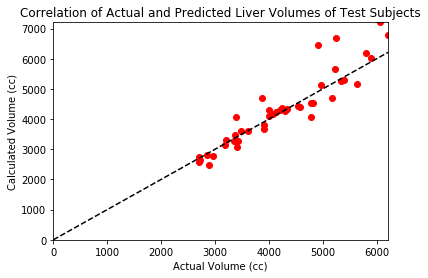

Correlation coefficient is 0.931


In [7]:
x = [r[1] for r in results]
y = [r[0] for r in results]
plt.figure()
plt.plot(x,y,'ro')
plt.plot(np.arange(0,np.max(x)),np.arange(0,np.max(x)),'k--')
plt.xlim([0,np.max(x)])
plt.ylim([0,np.max(y)])
plt.ylabel('Calculated Volume (cc)')
plt.xlabel('Actual Volume (cc)')
plt.title("Correlation of Actual and Predicted Liver Volumes of Test Subjects")
plt.show()
cc = np.corrcoef(x,y)[0,1]
print('Correlation coefficient is {:.03f}'.format(cc))